# K-Means Clustering

K-Means clustering is a method of vector quantization, originally from signal processing, that aims to partition `n` observations into `k` clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster.

<img src="k-means.jpg" alt="K-Means Clustering" width="600"/>

## The Algorithm
The K-Means algorithm consists of the following steps:

- Initialize `k` cluster centers (centroids) randomly.
- Repeat until convergence:
  - Assign each data point to the nearest centroid.
  - Recompute the centroids as the mean of all points assigned to that centroid.

Mathematically, the assignment step is often written as:

$$
c^{(i)} := \arg\min_{k} \|x^{(i)} - \mu_k\|^2
$$

where \\( c^{(i)} \\) is the index of the centroid closest to \\( x^{(i)} \\), and \\( \mu_k \\) is the position of the `k`-th centroid.

The update step can be written as:

$$
\mu_k := \frac{1}{|S_k|} \sum_{i\in S_k} x^{(i)}
$$

where \\( S_k \\) is the set of all points assigned to the `k`-th centroid.

The objective of K-Means is to minimize the total squared error between the data points and their corresponding cluster centroids.

## Silhouette Score

The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from `-1` to `+1`, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

The silhouette score is calculated using the mean intra-cluster distance ( \\( a \\) ) and the mean nearest-cluster distance ( \\( b \\) ) for each sample. The silhouette score for a single sample is given by:

$$
s = \frac{b - a}{\max(a, b)}
$$

The silhouette score for a set of samples is given as the mean of the silhouette score for each sample.


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin, silhouette_score

## Loading and Preprocessing the Dataset
Here we load the Penguins dataset using Seaborn and display the first few rows to understand the structure of the data.

We prepare the dataset for clustering by removing any missing values and isolating the numerical features, as K-Means requires numerical data to calculate distances.

Standardization of features is a common requirement for many machine learning estimators in `scikit-learn`; by standardizing features, we center the data around zero and scale it with respect to the standard deviation.

In [59]:
# Load the dataset
penguins = sns.load_dataset('penguins')

# Display the first few rows of the dataset
print(penguins.head())

# Preprocess the dataset: drop rows with missing values and select numeric columns only
penguins.dropna(inplace=True)
X = penguins.select_dtypes(include=[np.number])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female  


## K-Means Helper Functions
This section defines several helper functions that will be used in the K-Means algorithm, including functions for calculating distances, assigning labels to the nearest cluster, and updating cluster centers.


In [60]:
# Define the distance function
def distance(i, X, center):
    return np.sqrt(sum((X[i, j] - center[j])**2 for j in range(X.shape[1])))

# Define the function to assign a label to each data point
def assign_label(i, X, centers):
    distances = np.array([distance(i, X, center) for center in centers])
    label = np.argmin(distances)
    return label 

# Define the function to assign clusters
def assign_clusters(X, centers):
    return [assign_label(i, X, centers) for i in range(len(X))]

# Define the function to update centers
def update_centers(X, centers):
    current_labels = assign_clusters(X, centers)
    k = len(centers)
    center_means = {i : np.zeros(X.shape[1]) for i in range(k)}
    
    for i in range(len(X)):
        center_means[current_labels[i]] += X[i]

    for i in range(k):
        num_occur = current_labels.count(i)
        center_means[i] /= num_occur
    
    return [center_means[i] for i in center_means]


## K-Means Clustering Algorithm
We implement the K-Means clustering algorithm from scratch. This includes initializing centroids randomly, assigning points to the nearest centroids, updating centroids based on assignments, and repeating this process until convergence.


In [ ]:
# Define the k-means clustering algorithm
def k_means_clustering(X, k, max_iter=100):
    np.random.seed(42)  # Seed for reproducibility
    random_indices = np.random.choice(X.shape[0], k, replace=False)
    centers = X[random_indices]
    
    for _ in range(max_iter):
        labels = assign_clusters(X, centers)
        new_centers = update_centers(X, centers)
        
        if np.array_equal(centers, new_centers):
            break

        centers = new_centers

    return centers, labels

## Optimal Number of Clusters
The silhouette score is used to evaluate the optimal number of clusters for the K-Means algorithm. This score provides a perspective on the density and separation of the formed clusters.


In [61]:
# Function to calculate the silhouette score for a range of cluster numbers
def optimal_k(X, k_range):
    best_k = None
    best_score = -1
    for k in k_range:
        centers, labels = k_means_clustering(X, k)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_k = k
            best_score = score
    return best_k, best_score

## Finding the Best K
In this section, we apply the silhouette analysis to determine the best `k` value that suggests the optimal number of clusters for our dataset.


In [62]:
# Determine the optimal number of clusters
k_range = range(2, 10)
best_k, best_score = optimal_k(X_scaled, k_range)
print(f"Best number of clusters: {best_k}")
print(f"Best silhouette score: {best_score}")

Best number of clusters: 2
Best silhouette score: 0.5308173701641073


In [63]:
# Perform k-means clustering with the optimal number of clusters
centers, labels = k_means_clustering(X_scaled, best_k)

## Cluster Visualization
Finally, we visualize the clusters and their centroids. This visual representation helps us to understand the distribution of data and the effectiveness of the clustering algorithm.


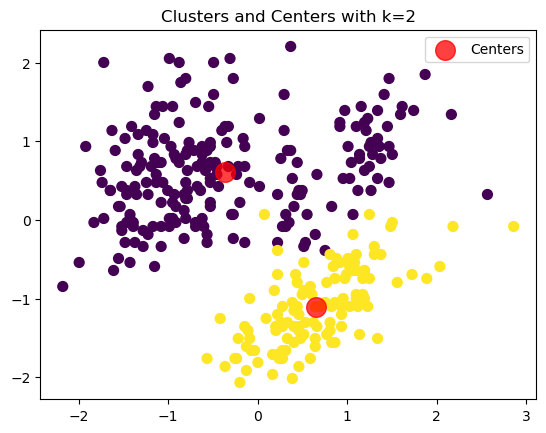

In [64]:
# Plot the clusters and their centers
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(centers_array[:, 0], centers_array[:, 1], c='red', s=200, alpha=0.75, label='Centers')
plt.title(f'Clusters and Centers with k={best_k}')
plt.legend()
plt.show()

## Conclusion

Based on the output of the K-Means algorithm, the dataset is best divided into two clusters. This is supported by a silhouette score of approximately 0.53, which suggests that the clusters are reasonably well-defined but not perfectly distinct. The visualization with two differently colored groups and clear centroids shows that the algorithm has found a meaningful way to separate the data into two groups, which could be useful for further data analysis or practical applications depending on the nature of the data.